GLRM Model
----------

What is a Low Rank Model?
-------------------------

-   **Given:** Data table *A* with m rows and n columns
-   **Find:** Compress representation as numeric tables *X* and *Y*,
    where \# cols in X = \# rows in Y = small user-specified k &lt;&lt;
    max(m, n)
-   \# cols in *Y* is d = (total dimension of embedded features in
    *A*) &gt;= n

In the example below, we are seeing the decomposition of A when A
consists of only numeric columns.

![](./images/GLRM.png "Title")

-   *Y* = archetypal features created from columns of *A*
-   *X* = row of *A* in reduced feature space
-   GLRM can approximately reconstruct *A* from product *XY*

GLRM Models Uses
----------------

GLRM models have multiple use cases:

-   filling in missing entries
-   reduce storage
-   remove noise
-   understand (visualize, cluster)



Understanding the Data
----------------------

We can use GLRM to understand the data. GLRM generates principal
components to interpret the data. Each row of Y is an archetypal feature
formed from the columns of A, and each row of X corresponds to a row of
A projected into this reduced dimension feature space.

For this tutorial, we will use data that contains attributes about a
house and its price in King County. The data is a public dataset from
Kaggle: <https://www.kaggle.com/harlfoxem/housesalesprediction>. We can
use GLRM to reduce the dimensions of the data 2 columns. We can use GLRM to reduce the dimensions of the data to 2 columns in order to visualize the houses data in a 2 dimensional plot.

We will begin by initializing the h2o cluster and importing the csv
file.



In [1]:
import h2o
from h2o.estimators import H2OGeneralizedLowRankEstimator

h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "9"; OpenJDK Runtime Environment (build 9+181); OpenJDK 64-Bit Server VM (build 9+181, mixed mode)
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_x0976g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [2]:
# Import Data
houses_data = h2o.import_file("./data/kc_house_data.csv")
houses_data.head()

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7.1293e+09,20141013T000000,221900,3,1,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6.4141e+09,20141209T000000,538000,3,2.25,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639
5.6315e+09,20150225T000000,180000,2,1,770,10000,1,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2.4872e+09,20141209T000000,604000,4,3,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1.9544e+09,20150218T000000,510000,3,2,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
7.23755e+09,20140512T000000,1.225e+06,4,4.5,5420,101930,1,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
1.3214e+09,20140627T000000,257500,3,2.25,1715,6819,2,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
2.008e+09,20150115T000000,291850,3,1.5,1060,9711,1,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
2.4146e+09,20150415T000000,229500,3,1,1780,7470,1,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
3.7935e+09,20150312T000000,323000,3,2.5,1890,6560,2,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [3]:
houses_data.shape

(21613, 21)

There are 3 columns that are being treated as integer that should be
converted to categorical or enum. The columns `condition`, `grade`, and
`view` are really ordinal columns so we will convert it to categorical.
Later on we can use ordinal loss for these functions. The column
`zipcode` is also being treated as an integer when it is really a
categorical column.

In [4]:
cat_cols = ['condition', 'grade', 'zipcode', 'view', 'waterfront']
houses_data[cat_cols]  = houses_data[cat_cols].asfactor()

When we define our first GLRM, we need to know which columns we want to
include in the model. In this case, we will not use `zipcode`, `id`, or
`date` since they have many unique values. We will also want to select
the loss function for GLRM. The GLRM model is trying to minimize this
loss function. It is tightly coupled to:

-   the use case
    -   some loss functions are sensitive to outliers and some are
        robust to outliers
-   the data type
    -   some loss functions are specific to the type of data in the
        column

For this example, we will try Absolute loss for the numeric features.
This loss will be robust to outliers. For the columns, `condition`,
`grade`, and `view`, we will use Ordinal loss.

In [5]:
glrm_cols = [x for x in houses_data.columns if x not in ["id", "date","zipcode"]]

'''calculate indexes of columns "condition","grade" and "view"'''
losses_idx = [houses_data.columns.index(x) for x in houses_data.columns if x in ["condition","grade","view"]]
losses_loss_f = ["Ordinal", "Ordinal", "Ordinal"]

rank2_model = H2OGeneralizedLowRankEstimator(k=2,
                                             model_id = "rank2", 
                                             seed = 1234, 
                                             loss="Absolute",
                                             loss_by_col=losses_loss_f,
                                             loss_by_col_idx=losses_idx,
                                             transform="standardize",
                                             representation_name="rank2_full")
rank2_model.train(training_frame=houses_data, 
                  x=glrm_cols
                 )

Model Details
H2OGeneralizedLowRankEstimator :  Generalized Low Rank Modeling
Model Key:  rank2


Model Summary: 


,,number_of_iterations,final_step_size,final_objective_value
0,,34.0,0.000098,432107.358306




ModelMetricsGLRM: glrm
** Reported on train data. **

MSE: NaN
RMSE: NaN
Sum of Squared Error (Numeric): 319289.7567706062
Misclassification Error (Categorical): 62969.0

Scoring History: 


,,timestamp,duration,iterations,step_size,objective
0,,2022-07-24 14:46:24,1.322 sec,0.0,0.666667,634295.070514
1,,2022-07-24 14:46:24,1.491 sec,1.0,0.444444,634295.070514
2,,2022-07-24 14:46:24,1.585 sec,2.0,0.222222,634295.070514
3,,2022-07-24 14:46:24,1.601 sec,3.0,0.074074,634295.070514
4,,2022-07-24 14:46:24,1.619 sec,4.0,0.018519,634295.070514
5,,2022-07-24 14:46:24,1.639 sec,5.0,0.003704,634295.070514
6,,2022-07-24 14:46:24,1.659 sec,6.0,0.003889,539113.650084
7,,2022-07-24 14:46:25,1.930 sec,7.0,0.004083,518293.371244
8,,2022-07-24 14:46:25,2.058 sec,8.0,0.002722,518293.371244
9,,2022-07-24 14:46:25,2.074 sec,9.0,0.002858,483792.966644



See the whole table with table.as_data_frame()


In [6]:
X = h2o.get_frame("rank2_full")
Y = rank2_model.archetypes()

In [7]:
print(X.shape)
print(len(Y), len(Y[0]))

(21613, 2)
2 38


In this case, the rows of Y represent some house attribute profiles. The
rows of X can be used to cluster houses.

Let’s visualize the first two archetypes of Y.

In [8]:
import pandas as pd

archetypes_cols = rank2_model._model_json["output"]["archetypes"].as_data_frame().reset_index(drop=True).columns.to_list()
archetypes_y = pd.DataFrame({'Arch1':Y[0],'Arch2':Y[1], 'attribute':archetypes_cols[1:]})
archetypes_y.head(n=20)

,Arch1,Arch2,attribute
0,2.224996,2.222383,grade1
1,2.224687,2.222075,grade3
2,2.221699,2.219099,grade4
3,2.196760,2.194261,grade5
4,1.986743,1.985091,grade6
5,2.061743,1.062541,grade7
6,0.893676,1.898060,grade8
7,0.912458,0.922905,grade9
8,0.279906,0.283366,grade10
9,0.057433,0.058152,grade11


In [9]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as pl
import random

pl.rcParams['figure.figsize'] = [15, 10]

ax1 = archetypes_y.plot.scatter(x='Arch1',
                                y='Arch2',
                                c='DarkBlue')
for i, txt in enumerate(archetypes_cols[1:]):
    if txt in ["sqft_lot", "sqft_lot15", "floors", "bedrooms", "price", "waterfront0", "waterfront1"]:
        ax1.annotate(txt, (Y[0][i]+random.uniform(-0.2,0.2), Y[1][i]+random.uniform(-0.2,0.2)))

#Don't display output of matplotlib
pl.close()

![archetypes\_y](./images/archetypes_y.png)

Attributes that are close together are considered similar. For example,
`sqft_lot` and `sqft_lot15` are very close together. This makes sense
since `sqft_lot` is the sqft of the lot where as `sqft_lot15` is the
sqft of the lot in 2015. Additionally `floors`, `bedrooms`, and `price`
are very close together. The values `waterfront0` and `waterfront1` are
far apart.

Now let’s visualize the first two archetypes of X.

In [10]:
x_df = X.as_data_frame()
x_df['id'] = houses_data['id'].as_data_frame()
archetypes_x = x_df.sample(n=100, random_state=1234)

# Include spesific houses to match R version of the notebook
include_houses = [5379802181, 3046200125]
for house in include_houses:
    if archetypes_x.loc[archetypes_x['id'].isin([house])].shape[0] == 0:
        archetypes_x = archetypes_x.append(x_df.loc[x_df['id'].isin([house])])
        
pl.rcParams['figure.figsize'] = [15, 10]

ax1 = archetypes_x.plot.scatter(x='Arch1',
                                y='Arch2',
                                c='DarkBlue')

#Color in Red two selected houses
custom_houses = archetypes_x.loc[archetypes_x['id'].isin(include_houses)].values.tolist()
ax1.scatter(custom_houses[0][0],custom_houses[0][1], color='#d62728')
ax1.scatter(custom_houses[1][0],custom_houses[1][1], color='#d62728')
#Don't display output of matplotlib
pl.close()        

![archetypes\_x\_highlighted](./images/archetypes_x_highlighted.png)

The houses in red are shown below:

|          id| date            |   price|  bedrooms|  bathrooms|  sqft\_living|  sqft\_lot|  floors| waterfront | view | condition | grade |  sqft\_above|  sqft\_basement|  yr\_built|  yr\_renovated| zipcode |      lat|      long|  sqft\_living15|  sqft\_lot15|
|-----------:|:----------------|-------:|---------:|----------:|-------------:|----------:|-------:|:-----------|:-----|:----------|:------|------------:|---------------:|----------:|--------------:|:--------|--------:|---------:|---------------:|------------:|
|  5379802181| 20141119T000000 |  193000|         2|          1|           680|       8640|       1| 0          | 0    | 4         | 5     |          680|               0|       1951|              0| 98188   |  47.4559|  -122.289|            1320|        13140|
|  3046200125| 20150406T000000 |  202000|         2|          1|           740|       6550|       1| 0          | 0    | 4         | 5     |          740|               0|       1946|              0| 98168   |  47.4807|  -122.332|            1080|         8515|

We can see that they have very similar sizes and price and were also
built during the same 5 year period.


### Transform (new) dataset

Demo `transform_frame(self, fr)` method. Available starting version 3.36.1.3
 1. GLRM performs `A=X*Y`  during training.  When a new dataset is given, GLRM will perform `Anew = Xnew*Y`.  
 2. When predict is called, `Xnew*Y` is returned.  
 3. When transform_frame is called, Xnew is returned instead.
 4. The method `return: an H2OFrame that contains Xnew` .
 
 In the below example we use the same dataset we have used to train the model. The method works the same on new dataset as well.

In [11]:
Xnew = rank2_model.transform_frame(houses_data)
print("Original data shape:", houses_data.shape)
print("Transformed data shape:",Xnew.shape)
Xnew.head()

Original data shape: (21613, 21)
Transformed data shape: (21613, 2)


Arch1,Arch2
0.942417,-0.160551
0.210512,0.331416
1.18075,-0.412068
0.754107,0.127383
0.59147,0.557455
-1.13326,2.83233
0.5756,0.622305
0.878726,-0.071743
0.704439,-0.201302
0.378564,0.881173


#### Clustering

Now that we’ve examined the archetypal space, we can cluster the houses
based on their archetypes. This is more effective than clustering on the
raw data because the raw data has noise and correlated attributes.

We can let H2O choose the best number of clusters by speciying
`estimate_k = TRUE`.

In [12]:
from h2o.estimators import H2OKMeansEstimator
kmeans_data = houses_data.cbind(X)
#kmeans_model = h2o.kmeans(kmeans_data, x = c("Arch1",  "Arch2"), estimate_k = TRUE, k = 100, seed = 1234)
kmeans_model = H2OKMeansEstimator(k=10,
                                  estimate_k=True,
                                  standardize=False,
                                  seed=1234)
kmeans_model.train(x=["Arch1",  "Arch2"], training_frame=kmeans_data)

# Eval performance:
perf = kmeans_model.model_performance()
print(perf)


ModelMetricsClustering: kmeans
** Reported on train data. **

MSE: NaN
RMSE: NaN
Total Within Cluster Sum of Square Error: 0.15637705630931298
Total Sum of Square Error to Grand Mean: 0.664998875819947
Between Cluster Sum of Square Error: 0.508621819510634

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,9951.0,0.074883
1,,2.0,11662.0,0.081494


Let’s visualize the clusters:

We will add the clusters to our original dataframe for vizualization purpose. For vizualization we will select same houses we sampled in the previous section.

In [13]:
clusters = kmeans_model.predict(kmeans_data)
clusters.col_names = ['cluster']
kmeans_data = kmeans_data.cbind(clusters)

kmeans_df = kmeans_data[["Arch1", "Arch2", "cluster", "id"]].as_data_frame()
kmeans_df = kmeans_df.loc[archetypes_x.index,:]

In [14]:
pl.rcParams['figure.figsize'] = [15, 10]
fig, ax = pl.subplots()
ax.scatter(kmeans_df['Arch1'], kmeans_df['Arch2'], c=kmeans_df['cluster'])
#Don't display output of matplotlib
pl.close()  

![clusters](./images/clusters.png) There are two clusters found. If we
examine these clusters, we can see that the top cluster represents more
expensive and larger houses with a higher grade.

In [15]:
kmeans_data.group_by("cluster").mean("price").mean("sqft_lot").mean("bedrooms").mean("grade").get_frame()

cluster,mean_price,mean_sqft_lot,mean_bedrooms,mean_grade
0,714144,20555.1,3.84263,6.43594
1,391569,10458.2,2.96827,4.9922


Filling in Missing Entries
--------------------------

Another use of GLRM would be to fill in any missing entries. We can view
missing entries as NA’s or events that have not yet happened. For
example, if we had data of customers and products, we could place NA’s
where a user has not yet purchased a product. In this way, by using GLRM
to impute missing values, we are also creating a recommender.

For our houses dataset, we do not having any missing values. We will
manually add missing values to our dataset to show how to use GLRM for
imputation.

### Split the Data

Given a training frame A, GLRM will produce a matrix factorization X and
Y. During validation, it approximately reconstructs A as a function of
the matrix product XY. This gives A = f(XY) which has the same number of
dimensions and features as A. Any missing values in A will also be
automatically filled in. Validation occurs by comparing A with the
validation frame and computing the squared error (for numeric entries)
and the number of mismatches (for categorical entries).

The correct way to do validation in GLRM is to take a dataset with no
(or very few) missing entries as your validation frame B. Create a deep
copy of B, then deliberately replace known values with missing values.

In [16]:
houses_data = h2o.assign(houses_data,"houses_data.hex")
miss_data = h2o.deep_copy(houses_data, "miss_data.hex")
miss_data.insert_missing_values(fraction = 0.15, seed = 1234)

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7.1293e+09,20141013T000000,221900,3,1,1180,5650,nan,0,0,3,7,nan,0,1955,0,98178,47.5112,-122.257,1340,nan
6.4141e+09,20141209T000000,538000,nan,nan,2570,7242,2,0,0,3,7,2170,nan,1951,1991,98125,47.721,-122.319,1690,nan
5.6315e+09,20150225T000000,180000,2,1,770,10000,1,0,,3,6,770,0,1933,nan,,47.7379,-122.233,2720,8062
2.4872e+09,20141209T000000,nan,4,3,1960,5000,1,0,0,5,7,1050,910,1965,0,,47.5208,nan,1360,5000
1.9544e+09,20150218T000000,nan,3,2,1680,8080,1,0,0,3,8,1680,0,1987,0,,47.6168,-122.045,nan,7503
nan,20140512T000000,1.225e+06,4,nan,nan,101930,1,0,,,,3890,nan,nan,0,98053,47.6561,-122.005,4760,nan
1.3214e+09,,257500,3,2.25,1715,6819,2,0,0,3,7,nan,0,1995,0,98003,nan,nan,2238,6819
2.008e+09,20150115T000000,291850,nan,1.5,1060,9711,nan,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,nan
2.4146e+09,20150415T000000,229500,nan,nan,1780,7470,1,,,3,,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
3.7935e+09,20150312T000000,323000,3,2.5,1890,6560,nan,0,0,3,7,1890,nan,2003,0,98038,47.3684,nan,2390,7570


We can now compare the number of NA’s between the two datasets:

In [17]:
print('Missing data in the original Data Frame:', houses_data.isna().sum())
print('Missing data in the modified Data Frame:', miss_data.isna().sum())

Missing data in the original Data Frame: 0.0
Missing data in the modified Data Frame: 68240.0


### Determining Best Parameters

The main parameters in the GLRM model are associated with rank,
regularization, loss, and initialization:

#### Rank

The size of the matrices *X* and *Y*. In the diagram, the rank is
denoted as `k`.

![](./images/GLRM.png)

#### Regularizations

| structure    | regularization\_x | regularization\_y |
|--------------|-------------------|-------------------|
| small        | Quadratic         | Quadratic         |
| sparse       | L1                | L1                |
| non negative | Non Negative      | Non Negative      |
| clustered    | Sparse            | None              |

#### Loss

| data type   | loss          | L(u, a)                                                  |
|-------------|---------------|----------------------------------------------------------|
| real        | quadratic     | ![quadratic\_loss](./images/quadratic_loss.gif)          |
| real        | absolute      | ![absolute\_loss](./images/absolute_loss.gif)            |
| real        | huber         | ![huber\_loss](./images/huber_loss.gif)                  |
| boolean     | hinge         | ![hinge\_loss](./images/hinge_loss.gif)                  |
| boolean     | logistic      | ![logistic\_loss](./images/logistic_loss.gif)            |
| integer     | poisson       | ![poisson\_loss](./images/poisson_loss.gif)              |
| ordinal     | ordinal hinge | ![ordinal\_hinge\_loss](./images/ordinal_hinge_loss.gif) |
| categorical | one-vs-all    | ![one\_vs\_all\_loss](./images/one_vs_all_loss.gif)      |

#### Initialization

The `init` parameter specifies how the X and Y matrices are initially
generated.

-   **Random:** random arrays from normal distribution
-   **PlusPlus:** initialization using the clusters from k-means++
    initialization.
-   **SVD:** initialization using the first k right singular values.
    Helps with global convergence for matrix factorizations where global
    convergence not guaranteed (ex Non Negative Matrix Factorization)

In this tutorial, we will start by building a model using the default
parameters. We will set the rank (`k`) of the model to 5 and the
regularization strength to 2. We will tune these parameters later on. We
will also tell the GLRM model to use Ordinal loss for our ordinal
columns: `view`, `condition`, and `grade`.

In [18]:
glrm_k = 5
gamma  = 2

glrm_cols = [x for x in houses_data.columns if x not in ["id", "date","zipcode"]]

'''calculate indexes of columns "condition","grade" and "view"'''
losses_idx = [houses_data.columns.index(x) for x in houses_data.columns if x in ["condition","grade","view"]]
losses_loss_f = ["Ordinal", "Ordinal", "Ordinal"]

base_model = H2OGeneralizedLowRankEstimator(k=glrm_k,
                                             gamma_x = gamma, 
                                             gamma_y = gamma,
                                             model_id = "base_glrm_model", 
                                             seed = 1234, 
                                             regularization_x = "Quadratic", 
                                             regularization_y = "Quadratic",
                                             loss="Absolute",
                                             loss_by_col=losses_loss_f,
                                             loss_by_col_idx=losses_idx,
                                             representation_name="base_glrm_frame")

base_model.train(training_frame=miss_data, 
                 validation_frame = houses_data,
                 x=glrm_cols)

# Let’s take a look at the validation error
print(base_model.model_performance(valid=True))


ModelMetricsGLRM: glrm
** Reported on validation data. **

MSE: NaN
RMSE: NaN
Sum of Squared Error (Numeric): 3262887894484737.5
Misclassification Error (Categorical): 57857.0



We have a very high numeric error. We are also misclassifying more than 50% of the categorical values.  
Let’s improve this by transforming the numerical values in the dataset.  
This is advised because some columns may have very large means which may cause our model to be biased.  
Since we are transforming the data, we make sure to include `impute_original = True`. This will reverse the transformation during prediction.

In [19]:
standardized_model = H2OGeneralizedLowRankEstimator(k=glrm_k,
                                                    gamma_x = gamma, 
                                                    gamma_y = gamma,
                                                    model_id = "standardized_glrm_model", 
                                                    seed = 1234, 
                                                    regularization_x = "Quadratic", 
                                                    regularization_y = "Quadratic",
                                                    loss="Absolute",
                                                    loss_by_col=losses_loss_f,
                                                    loss_by_col_idx=losses_idx,
                                                    representation_name="standardized_glrm_frame",
                                                    impute_original = True,
                                                    transform = "STANDARDIZE", )

standardized_model.train(training_frame=miss_data, 
                         validation_frame = houses_data,
                         x=glrm_cols)

# Let’s take a look at the validation error
print(standardized_model.model_performance(valid=True))


ModelMetricsGLRM: glrm
** Reported on validation data. **

MSE: NaN
RMSE: NaN
Sum of Squared Error (Numeric): 2134773085652903.8
Misclassification Error (Categorical): 62969.0



In [20]:
standardized_model.model_performance(valid=False).num_err()

1858581575013018.5

Here we see a great reduction in the numeric error.

### Effects of Rank

Rank controls the size of our decomposed matrices. If our rank is too
low, we will have high error because we are not including some
archetypes. If our rank is too high, our X and Y matrices are
unnecessarily large and this may cause overfitting. We will examine how
different ranks effect the reconstruction error on the validation data
by training a GLRM model for the ranks 1, 3, 5, …, 21.

In [21]:
k_range = [1,5,9,13,17,21]
perf_train_arr = []
perf_valid_arr = []

for k in k_range:
    k_model = H2OGeneralizedLowRankEstimator(k=k,
                                            gamma_x = gamma, 
                                            gamma_y = gamma,
                                            model_id = "k_glrm_model_"+str(k), 
                                            seed = 1234, 
                                            regularization_x = "Quadratic", 
                                            regularization_y = "Quadratic",
                                            loss="Absolute",
                                            loss_by_col=losses_loss_f,
                                            loss_by_col_idx=losses_idx,
                                            representation_name="k_glrm_frame_"+str(k),
                                            impute_original = True,
                                            transform = "STANDARDIZE" )

    k_model.train(training_frame=miss_data, 
                  validation_frame = houses_data,
                  x=glrm_cols)

    perf_train_arr.append(k_model.model_performance(valid=False).num_err())
    perf_valid_arr.append(k_model.model_performance(valid=True).num_err())

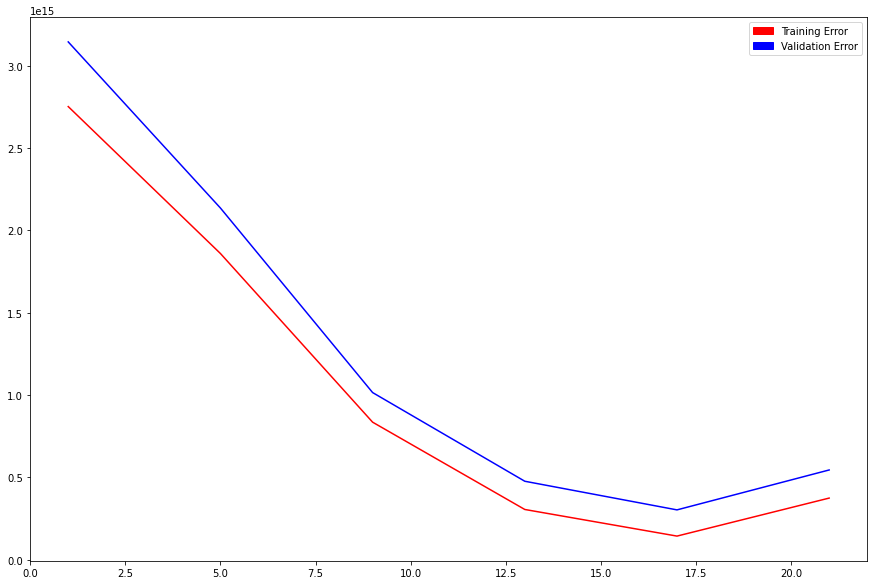

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams['figure.figsize'] = [15, 10]
fig, ax = plt.subplots()
ax.plot(k_range, perf_train_arr,c='r')
ax.plot(k_range, perf_valid_arr, c='b')
red_patch = mpatches.Patch(color='r', label='Training Error')
blue_patch = mpatches.Patch(color='b', label='Validation Error')
ax.legend(handles=[red_patch, blue_patch])
plt.show()

Based on our plot, it looks like
our optimal k is 17. After this value, the improvement plateaus. If our
aim was to lower the dimensionality of the data, we could choose the
elbow of the graph as `k`. In this case, the elbow is round `k = 9`.

The plot of the validation error should helps us to determine the
true rank of the data. The true rank of the data should encompass the
signal of the data, not the noise. When we see that the validation error
is increasing as k increases, the low rank matrix is beginning to
capture not just the signal but also the noise.

### Effects of Regularization Strength

Regularization strength is especially important if there are a lot of
missing values in the data to prevent overfitting. Regularization is
added to the loss function so that our new goal is to mimimize:

![loss\_equation](./images/loss_equation.gif)

We will examine how different regularization strengths effect the
reconstruction error on the validation data when `k = 17`. In a future
version of this tutorial, we will run a grid search over both `k` and
`gamma` since the effects of each parameter are dependent of each other.

In [23]:
gamma_range = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,3,4,5]
perf_train_arr = []
perf_valid_arr = []

for gamma in gamma_range:
    gamma_model = H2OGeneralizedLowRankEstimator(k=17,
                                                gamma_x = gamma, 
                                                gamma_y = gamma,
                                                model_id = "gamma_glrm_model_"+str(gamma), 
                                                seed = 1234, 
                                                regularization_x = "Quadratic", 
                                                regularization_y = "Quadratic",
                                                loss="Absolute",
                                                loss_by_col=losses_loss_f,
                                                loss_by_col_idx=losses_idx,
                                                representation_name="gamma_glrm_frame_"+str(gamma),
                                                impute_original = True,
                                                transform = "STANDARDIZE" )

    gamma_model.train(training_frame=miss_data, 
                      validation_frame = houses_data,
                      x=glrm_cols)

    perf_train_arr.append(gamma_model.model_performance(valid=False).num_err())
    perf_valid_arr.append(gamma_model.model_performance(valid=True).num_err())

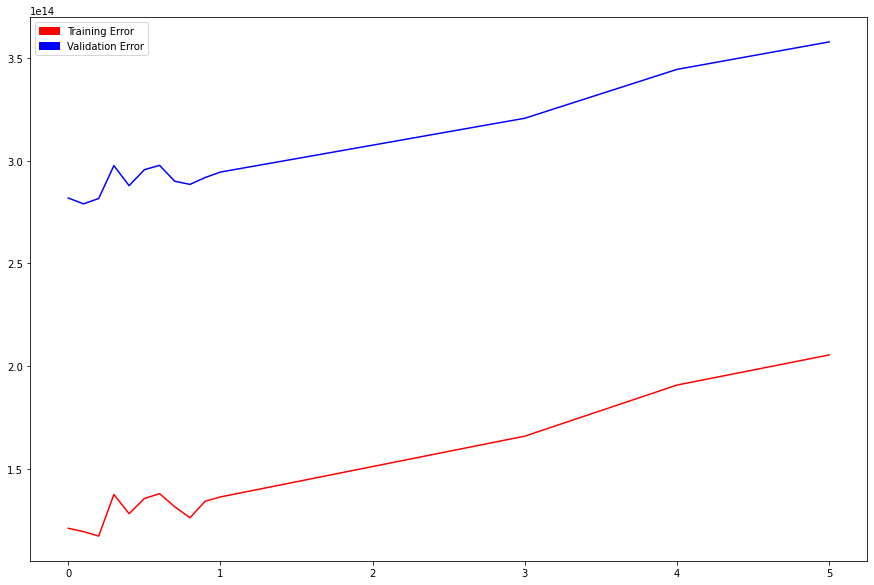

In [24]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, ax = plt.subplots()
ax.plot(gamma_range, perf_train_arr,c='r')
ax.plot(gamma_range, perf_valid_arr, c='b')
red_patch = mpatches.Patch(color='r', label='Training Error')
blue_patch = mpatches.Patch(color='b', label='Validation Error')
ax.legend(handles=[red_patch, blue_patch])
plt.show()

The relationship between regularization strength and validation error shows a different story than what we saw with rank. Some regularization helps improve the validation error but too much hurts the performance. It looks like we have the best Validation performance with a regularization strength around 0.1 .

### Our Final Model

Below we generate the final model and view the performance metrics.

In [25]:
final_glrm = H2OGeneralizedLowRankEstimator(k=17,
                                            gamma_x = 0.1, 
                                            gamma_y = 0.1,
                                            model_id = "final_glrm_model_", 
                                            seed = 1234, 
                                            regularization_x = "Quadratic", 
                                            regularization_y = "Quadratic",
                                            loss="Absolute",
                                            loss_by_col=losses_loss_f,
                                            loss_by_col_idx=losses_idx,
                                            representation_name="final_glrm_frame",
                                            impute_original = True,
                                            transform = "STANDARDIZE" )
final_glrm.train(training_frame=miss_data, 
                 validation_frame = houses_data,
                 x=glrm_cols)
print(final_glrm.model_performance(valid = True))


ModelMetricsGLRM: glrm
** Reported on validation data. **

MSE: NaN
RMSE: NaN
Sum of Squared Error (Numeric): 278994325336073.25
Misclassification Error (Categorical): 62566.0



### Matrix Completion and Denoising

Matrix Completion and Denoising occur by multiplying the matrices X and
Y (if the original data was numeric) or using the function `h2o.predict`
(in the event of mixed data types).

In our `miss_data`, we manually created ~68k missing values. We will use
our final GLRM model to impute these missing values.

In [26]:
# Predict data based on low rank matrices
houses_pred = final_glrm.predict(miss_data)

# Add House ID as first column
houses_pred = miss_data['id'].cbind(houses_pred)

Let’s take a look at the number of missing values in the predicted data.

In [27]:
print('Missing data in Data Frame imputed with missing values:', miss_data.isna().sum())
# 68240.0
print('Missing data in the transformed by GLRM Data Frame :', houses_pred[1:].isna().sum())
# 0

Missing data in Data Frame imputed with missing values: 68240.0
Missing data in the transformed by GLRM Data Frame : 0.0


Let’s examine the first record which had missing values added to the
features `floors` and `sqft_above`.

In [28]:
houses_data[['floors','sqft_above']].head(1)

floors,sqft_above
1,1180


In [29]:
houses_pred[['reconstr_floors','reconstr_sqft_above']].head(1)

reconstr_floors,reconstr_sqft_above
1.12398,1177.52



|  floors|  sqft\_above|
|-------:|------------:|
|       1|         1180|

|  reconstr\_floors|  reconstr\_sqft\_above|
|-----------------:|----------------------:|
|          1.12398 |               1177.52 |

The GLRM model is able to correctly estimate the number of floors and
the sqft of the interior above the ground level.

Compressing Data
----------------

If the goal of GLRM is to compress data, then choosing the best rank of
the model may be done slightly differently. As seen before, we want to
minimize the error on a validation dataset, however, now we need to keep
in mind the compression rate.

Compression Rate = Number of Non Zeros is X and Y Matrices/ Number of
Non Zeros in original data

If the decomposed matrices are dense, then the compression rate is
simply =
`(num rows of X + num cols of Y)*k/(num cols of A * num rows of A)`
where A is the original data.

We have a dense decomposition because we have used the quadratic
regularization. Therefore, the compression rate is
`((1470 + 77)*9)/(1470*35) = 27%`. We may choose to compress further by
using an L1 regularization instead of L2.

If we need to achieve a compression rate of 10%, then we would choose
the rank that minimizes the validation error under the restriction that
the compression rate is &lt;= 10%.